In [48]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [49]:
# Load the data
csv_path = './CrabAgePrediction.csv'
data = pd.read_csv(csv_path)

# load Features and Labels
# using x _features
# "Sex", "Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Age"
x_features = ["Length", "Diameter", "Height", "Weight", "Shucked Weight", "Viscera Weight", "Shell Weight"]
# to predict Age
y_target = ["Age"]

x = data[x_features]
y = data[y_target]

print(x.head())
print(y.head())

# load with torch
x_tensor = torch.tensor(x.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

   Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0  1.4375    1.1750  0.4125  24.635715       12.332033        5.584852   
1  0.8875    0.6500  0.2125   5.400580        2.296310        1.374951   
2  1.0375    0.7750  0.2500   7.952035        3.231843        1.601747   
3  1.1750    0.8875  0.2500  13.480187        4.748541        2.282135   
4  0.8875    0.6625  0.2125   6.903103        3.458639        1.488349   

   Shell Weight  
0      6.747181  
1      1.559222  
2      2.764076  
3      5.244657  
4      1.700970  
   Age
0    9
1    6
2    6
3   10
4    6


size of pred_soln: torch.Size([779, 1])
size of y_test: torch.Size([779, 1])
MSE: 4.830881207760181
RMSE: 2.197926570147461


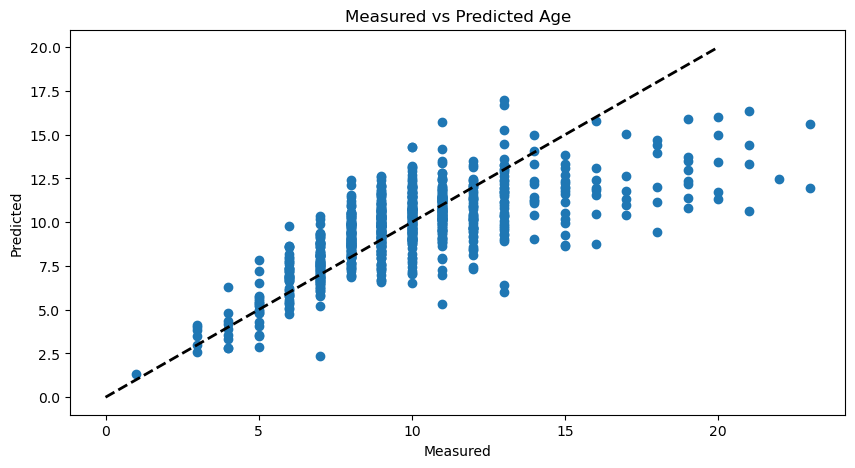

In [52]:
# Split the data into training and test sets
testing_fraction = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=testing_fraction, random_state=42)


# compute the pseudo-inverse
# (A^TA)^{-1}A^T
Pinv = torch.linalg.pinv(x_train)

# compute the weights
# x=((A^TA)^{-1}A^T)b
weights = Pinv @ y_train

# prediction is then A*x=b
# b is y_pred
y_pred = x_test @ weights

print(f'size of pred_soln: {y_pred.size()}')
print(f'size of y_test: {y_test.size()}')


# compute the mean squared error between the predicted and actual values

avg_MSE = mean_squared_error(y_test, y_pred)
print(f'MSE: {avg_MSE}')
# compute RMSE
RMSE = np.sqrt(avg_MSE)
print(f'RMSE: {RMSE}')

MSE_tensor = torch.nn.functional.mse_loss(y_test, y_pred, reduction='none')  # No reduction to get per-sample errors

plt.figure(figsize=(10, 5))
# plot predicted vs actual
plt.plot(y_test, y_pred, 'o')
# Fit a line to the data
plt.plot([0,20], [0,20], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Age')
plt.show()